In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as tgrad
from torch.autograd import Variable

import os
import time
import utils
import numpy as np

from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import networks
import importlib

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

True
cuda


# Data Sampling
Here in our case, the system is European Call Option PDE and the physical information about the system consists of Boundary Value conditions, final Value conditions and the PDE itself.

In [3]:
K = 10
r = 0.035
sigma = 0.2
T = 1
S_range = [0, int(5*K)]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)
M = 100
N = 5000

# Build Neural Network

In [4]:
pinn = networks.FeedforwardNeuralNetwork(2, 50, 1, 8) #  Network initialization
pinn.cuda()

FeedforwardNeuralNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1-7): 7 x Linear(in_features=50, out_features=50, bias=True)
  )
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)

In [5]:
n_epochs = 2000
lossFunction = nn.MSELoss()
lr = 3e-5
optimizer = optim.Adam(pinn.parameters(), lr=lr)

x_f_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_ic_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_bc_s = torch.tensor(0.).float().to(device).requires_grad_(True)
x_data_s = torch.tensor(0.).float().to(device).requires_grad_(True)
optimizer_adam_weight = torch.optim.Adam([x_f_s] + [x_bc_s] + [x_data_s] + [x_ic_s], lr=lr*0.01)

In [6]:
# physical loss samples
samples = {"pde": 5000, "bc":500, "fc":500}

# sample data generated by finite difference method
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = utils.fdm_data(S_range[-1], T, M, N, "500000sample.csv", device)

# Modelling


In [7]:
mse_loss_hist = []
ic_loss_hist = []
bc_loss_hist = []
data_loss_hist = []
pde_loss_hist = []

start_time = time.time()
for epoch in range(n_epochs):
    i_st_train, i_v_train, bc_st_train, bc_v_train, n_st_train, n_v_train = \
    utils.trainingData3(K, r, sigma, T, S_range[-1], S_range, t_range, gs, 
                       samples['bc'], 
                       samples['fc'], 
                       samples['pde'], 
                       RNG_key=123)
    
    # save training data points to tensor and send to device
    i_st_train = torch.from_numpy(i_st_train).float().requires_grad_().to(device)
    i_v_train = torch.from_numpy(i_v_train).float().to(device)
    
    n_st_train = torch.from_numpy(n_st_train).float().requires_grad_().to(device)
    n_v_train = torch.from_numpy(n_v_train).float().to(device)
    
    bc_st_train = torch.from_numpy(bc_st_train).float().to(device)
    bc_v_train = torch.from_numpy(bc_v_train).float().to(device)
    
    # PDE Round
    y1_hat = pinn(n_st_train)
    grads = tgrad.grad(y1_hat, n_st_train, grad_outputs=torch.ones(y1_hat.shape).cuda(), retain_graph=True, create_graph=True, only_inputs=True)[0]
    # print(grads)
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = tgrad.grad(dVdS, n_st_train, grad_outputs=torch.ones(dVdS.shape).cuda(), create_graph=True, only_inputs=True)[0]
    # print(grads2nd)
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = n_st_train[:, 1].view(-1, 1)
    pde_loss = lossFunction(-dVdt, 0.5*((sigma*S1)**2)*d2VdS2 + r*S1*dVdS - r*y1_hat)
    
    # BC Round
    y2_hat = pinn(bc_st_train)
    bc_loss = lossFunction(bc_v_train, y2_hat)
    
    # initial condition loss
    ic_hat = pinn(i_st_train)
    ic_loss = lossFunction(i_v_train, ic_hat)
    
    # data Round
    y3_hat = pinn(X_train_tensor)
    data_loss = lossFunction(y_train_tensor, y3_hat)
    
    # Backpropagation and Update
    optimizer.zero_grad()
    combined_loss = torch.exp(-x_f_s.detach()) * pde_loss + torch.exp(-x_bc_s.detach()) * bc_loss + torch.exp(-x_data_s.detach()) * data_loss + torch.exp(-x_ic_s.detach()) * ic_loss + x_ic_s + x_data_s + x_bc_s + x_f_s
    combined_loss.backward()
    optimizer.step()
    
    # update the weight
    optimizer_adam_weight.zero_grad()
    loss = torch.exp(-x_f_s) * pde_loss.detach() + torch.exp(-x_bc_s) * bc_loss.detach() + torch.exp(-x_data_s) * data_loss.detach() + torch.exp(-x_ic_s) * ic_loss.detach() + x_ic_s + x_data_s + x_bc_s + x_f_s
    loss.backward()
    optimizer_adam_weight.step()
    
    # record the loss
    mse_loss = pde_loss + bc_loss + data_loss + ic_loss
    mse_loss_hist.append(mse_loss.item())
    if epoch % 500 == 0:
        print(f'{epoch}/{n_epochs} PDE Loss: {pde_loss.item():.5f}, BC Loss: {bc_loss.item():.5f}, data loss: {data_loss.item():.5f}, ic loss: {ic_loss.item():.5f},  total loss: {mse_loss.item():.5f}, minimum loss: {min(mse_loss_hist):.5f}')
        print(f'the weight is {torch.exp(-x_f_s.detach()).item():.5f}, {torch.exp(-x_bc_s.detach()).item():.5f}. {torch.exp(-x_data_s.detach()).item():.5f}, {torch.exp(-x_ic_s.detach()).item():.5f}')
    pass

end_time = time.time()
print('run time:', end_time - start_time)

0/2000 PDE Loss: 0.00001, BC Loss: 809.34137, data loss: 426.13452, ic loss: 412.28961,  total loss: 1647.76538, minimum loss: 1647.76538
the weight is 1.00000, 1.00000. 1.00000, 1.00000
500/2000 PDE Loss: 0.00044, BC Loss: 252.96254, data loss: 115.34142, ic loss: 109.32729,  total loss: 477.63165, minimum loss: 477.63165
the weight is 1.00015, 0.99986. 0.99987, 0.99987
1000/2000 PDE Loss: 0.14827, BC Loss: 2.66755, data loss: 9.57948, ic loss: 9.30324,  total loss: 21.69855, minimum loss: 21.69855
the weight is 1.00030, 0.99986. 0.99986, 0.99986
1500/2000 PDE Loss: 0.30699, BC Loss: 0.02634, data loss: 0.16569, ic loss: 0.06635,  total loss: 0.56536, minimum loss: 0.56536
the weight is 1.00040, 0.99986. 0.99985, 0.99985
run time: 36.59478163719177


Text(0.5, 1.0, 'AWPINN loss')

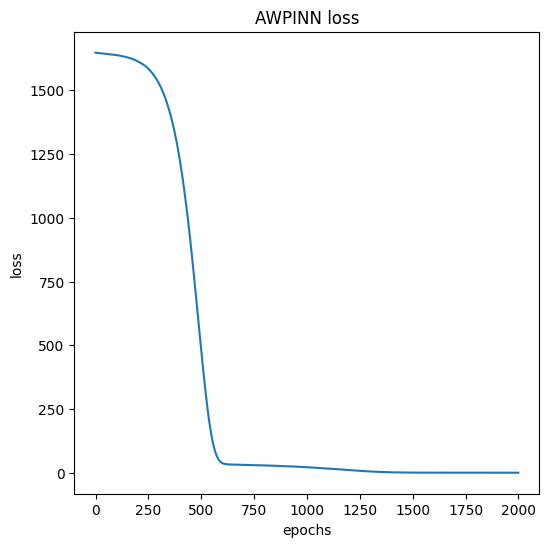

In [8]:
fig = plt.figure(figsize=(6,6))
plt.plot(range(n_epochs), mse_loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('AWPINN loss')

In [9]:
# Evaluate the model on the test set
pinn.eval()
with torch.no_grad():
    test_outputs = pinn(X_test_tensor)
    test_loss = lossFunction(test_outputs, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.0054


In [10]:
for i in range(2000):
    if i % 500 == 0:
        print(mse_loss_hist[i])

1647.765380859375
477.63165283203125
21.698551177978516
0.5653640627861023
